# import packages

In [1]:
import numpy as np
import pandas as pd
import math
import random
import itertools
import time

# visualization
import seaborn as sns
sns.set_style('darkgrid')

# date libraries
import datetime
import holidays
from datetime import date, timedelta, datetime

# matplotlib libraries
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter
import matplotlib.dates as mdates

# scipy library
from scipy import stats
from scipy.stats import norm

# sklearn library
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# prophet library
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric
from prophet.diagnostics import performance_metrics, cross_validation


/home/lordmax/.virtualenvs/jupyterworld/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# mean absolute percentage error function
def mape(actual, pred):
    '''
    Mean Absolute Percentage Error (MAPE) Function

    input: list/series for actual values and predicted values
    output: mape value
    '''

    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [5]:
datapath = '../relevant_stock_market_data2.csv'
data = pd.read_csv(datapath, parse_dates=['DATE'], index_col='DATE')

In [6]:
data

,SYMBOL,CLOSEPRICE,SECTOR
DATE,,,
2003-01-02,ACADEMY,0.53,SERVICES
2003-01-03,ACADEMY,0.53,SERVICES
2003-01-06,ACADEMY,0.53,SERVICES
2003-01-07,ACADEMY,0.53,SERVICES
2003-01-08,ACADEMY,0.53,SERVICES
...,...,...,...
2023-02-22,ZENITHBANK,25.20,FINANCIAL SERVICES
2023-02-23,ZENITHBANK,25.35,FINANCIAL SERVICES
2023-02-24,ZENITHBANK,25.75,FINANCIAL SERVICES


In [7]:
data.SECTOR.nunique()

12

In [8]:
data.SECTOR.unique()

array(['SERVICES', 'FINANCIAL SERVICES', 'NATURAL RESOURCES',
       'CONSTRUCTION/REAL ESTATE', 'OIL AND GAS', 'INDUSTRIAL GOODS',
       'CONSUMER GOODS', 'CONGLOMERATES', 'HEALTHCARE', 'AGRICULTURE',
       'ICT', 'UTILITIES'], dtype=object)

In [13]:
utilities_tsdata = data[data['SECTOR'] == 'UTILITIES']
utilities_tsdata

,SYMBOL,CLOSEPRICE,SECTOR
DATE,,,
2022-10-04,GEREGU,100.0,UTILITIES
2022-10-05,GEREGU,110.0,UTILITIES
2022-10-06,GEREGU,120.9,UTILITIES
2022-10-07,GEREGU,120.9,UTILITIES
2022-10-11,GEREGU,120.9,UTILITIES
...,...,...,...
2023-02-22,GEREGU,246.4,UTILITIES
2023-02-23,GEREGU,255.0,UTILITIES
2023-02-24,GEREGU,255.0,UTILITIES


In [14]:
del utilities_tsdata['SECTOR']

In [15]:
utilities_tsdata.columns

Index(['SYMBOL', 'CLOSEPRICE'], dtype='object')

In [16]:
pivoted_data = utilities_tsdata.pivot(columns='SYMBOL', values='CLOSEPRICE')

In [20]:
# Resample the data with daily frequency by interpolation
geregu_tsdata = pivoted_data.resample('D').interpolate(method='linear')

In [21]:
geregu_tsdata.fillna(0, inplace=True)

In [22]:
geregu_tsdata.tail()

SYMBOL,GEREGU
DATE,
2023-02-24,255.000000
2023-02-25,259.833333
2023-02-26,264.666667
2023-02-27,269.500000
2023-02-28,275.500000


# visualization

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


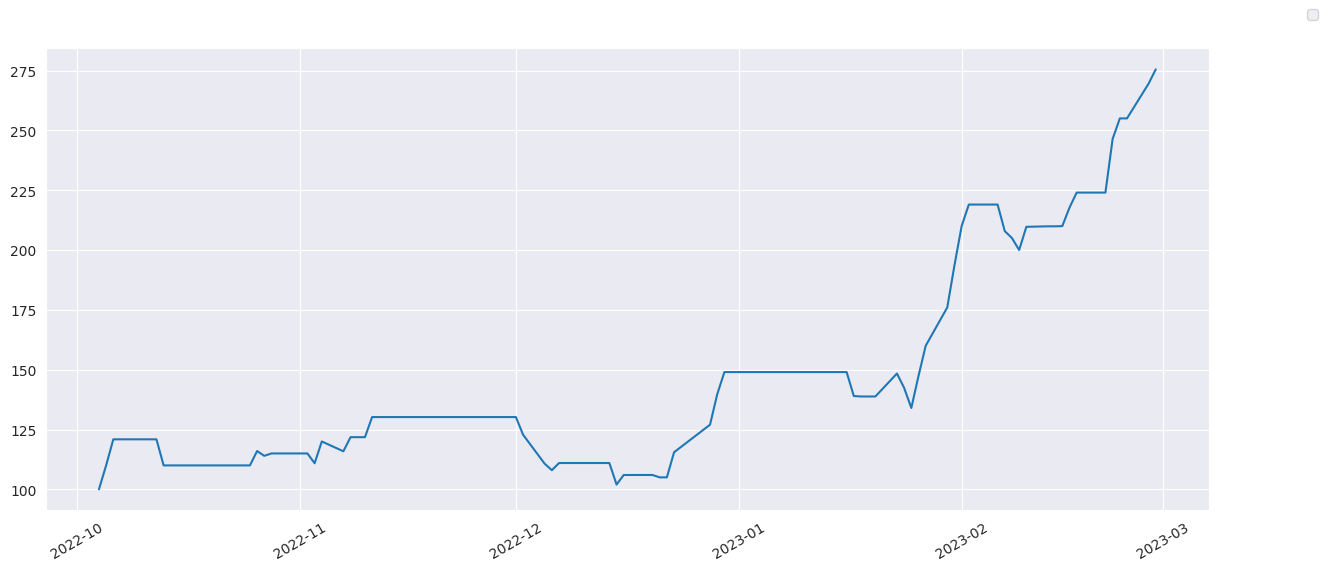

In [29]:
# Plotting
plt.figure(figsize=(15, 6))
plt.plot(geregu_tsdata)
plt.legend(loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

# modelling

### (1.) cadbury

In [30]:
# stock variable
feature = 'GEREGU'
prediction_days = 59 #last 59 days

In [31]:
df_cadbury = geregu_tsdata[[feature]].reset_index()
df_cadbury.head()

SYMBOL,DATE,GEREGU
0,2022-10-04,100.0
1,2022-10-05,110.0
2,2022-10-06,120.9
3,2022-10-07,120.9
4,2022-10-08,120.9


In [44]:
#adding holiday data

holiday = pd.DataFrame([])

nigerian_holidays = holidays.NG()  # this is a dict
# the below is the same, but takes a string:
nigerian_holidays = holidays.country_holidays('NG')  # this is a dict


for date_, name in sorted(holidays.NG(years=[2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023]).items()):
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date_, 'holiday': "NG-Holidays", 'lower_window': -2, 'upper_window': 1}, index=[0])], ignore_index=True) 

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')
holiday.head()

,ds,holiday,lower_window,upper_window
0,2003-01-01,NG-Holidays,-2,1
1,2003-02-11,NG-Holidays,-2,1
2,2003-02-12,NG-Holidays,-2,1
3,2003-04-18,NG-Holidays,-2,1
4,2003-04-21,NG-Holidays,-2,1


In [52]:
forecast_start_dt = date(2023,1,1)
forecast_start_date = (forecast_start_dt).strftime('%Y-%m-%d')
forecast_start_date
# forecast_start_date = max(df_geregu.index) - timedelta(prediction_days)

'2023-01-30'

In [54]:
df_geregu_copy = df_geregu.copy()
df_geregu_copy = df_geregu_copy.rename(columns={'DATE': 'ds', feature: 'y'})
df_geregu_copy[['y']] = df_geregu_copy[['y']].apply(pd.to_numeric) # make sure that 'y' featrue is a numeric datatype

# affirming that 'ds' is in datetime datatype
df_geregu_copy['ds'] = pd.to_datetime(df_geregu_copy['ds'])

# train data
train_set = df_geregu_copy[(df_geregu_copy['ds'] < forecast_start_date)]

# baseline model
m = Prophet()
m.fit(train_set)
future = m.make_future_dataframe(periods=prediction_days)
fcst_prophet_train = m.predict(future)

# filter to add only forecasted data to predicted_df
filter = fcst_prophet_train['ds'] >= forecast_start_date
predicted_df = fcst_prophet_train[filter][['ds', 'yhat']]

16:35:26 - cmdstanpy - INFO - Chain [1] start processing
16:35:57 - cmdstanpy - INFO - Chain [1] done processing


In [55]:
# merging the original data with the predicted data
df_geregu_copy = df_geregu_copy.copy()
df_geregu_copy.columns = ['ds', 'yoriginal']
predicted_df = predicted_df.merge(df_geregu_copy)

In [58]:
predicted_df

,ds,yhat,yoriginal
0,2023-01-30,11.136367,12.25
1,2023-01-31,11.174169,12.25
2,2023-02-01,11.304340,12.25
3,2023-02-02,11.383695,12.25
4,2023-02-03,11.505150,12.30
5,2023-02-04,11.563866,12.30
6,2023-02-05,11.621267,12.30
7,2023-02-06,11.675671,12.30
8,2023-02-07,11.706750,11.90
9,2023-02-08,11.826798,11.90


In [61]:
mape(predicted_df['yoriginal'], predicted_df['yhat'])

3.385376331016062

In [62]:
100 - mape(predicted_df['yoriginal'], predicted_df['yhat'])

96.61462366898394

# cross validation

In [64]:
df_geregu_cv = cross_validation(m, initial='365.25 days', period='365.25 days', horizon='59 days')


  0%|                                                    | 0/19 [00:00<?, ?it/s]16:45:21 - cmdstanpy - INFO - Chain [1] start processing
16:45:21 - cmdstanpy - INFO - Chain [1] done processing

  5%|██▎                                         | 1/19 [00:00<00:14,  1.22it/s]16:45:22 - cmdstanpy - INFO - Chain [1] start processing
16:45:23 - cmdstanpy - INFO - Chain [1] done processing

 11%|████▋                                       | 2/19 [00:02<00:24,  1.42s/it]16:45:24 - cmdstanpy - INFO - Chain [1] start processing
16:45:26 - cmdstanpy - INFO - Chain [1] done processing

 16%|██████▉                                     | 3/19 [00:05<00:33,  2.11s/it]16:45:27 - cmdstanpy - INFO - Chain [1] start processing
16:45:32 - cmdstanpy - INFO - Chain [1] done processing

 21%|█████████▎                                  | 4/19 [00:11<00:52,  3.49s/it]16:45:32 - cmdstanpy - INFO - Chain [1] start processing
16:45:37 - cmdstanpy - INFO - Chain [1] done processing

 26%|███████████▌            

In [66]:
df_p = performance_metrics(df_geregu_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,6 days 00:00:00,118.465960,10.884207,7.720126,0.348554,0.191130,0.391746,0.439286
1,6 days 06:00:00,119.775454,10.944197,7.803098,0.351723,0.210661,0.397502,0.430357
2,6 days 12:00:00,119.538937,10.933386,7.808835,0.350304,0.210661,0.403403,0.424107
3,6 days 18:00:00,117.770558,10.852214,7.817916,0.355615,0.210661,0.407009,0.417857
4,7 days 00:00:00,120.724369,10.987464,7.834057,0.354032,0.208954,0.402286,0.430357


In [70]:
df_geregu_cv['mape'] = (df_geregu_cv['y'] - df_geregu_cv['yhat']) / (df_geregu_cv['y']) * 100
df_geregu_cv['overestimate'] = df_geregu_cv['yhat'] > df_geregu_cv['y']

df_geregu_cv.sort_values('mape', ascending=False)#.head(10)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,mape,overestimate
747,2017-01-09,-2.746678,-10.924994,4.812312,9.030000,2016-11-30 12:00:00,130.417248,False
748,2017-01-10,-2.805546,-10.516522,4.279284,9.280000,2016-11-30 12:00:00,130.232172,False
755,2017-01-17,-2.732418,-11.081628,4.876176,9.130000,2016-11-30 12:00:00,129.927906,False
746,2017-01-08,-2.713112,-10.057682,4.759576,9.186667,2016-11-30 12:00:00,129.533146,False
754,2017-01-16,-2.700641,-10.027275,5.171341,9.180000,2016-11-30 12:00:00,129.418749,False
...,...,...,...,...,...,...,...,...
291,2009-01-25,41.339410,35.558115,47.033389,13.583333,2008-11-30 12:00:00,-204.339215,True
697,2016-01-19,36.681218,25.430475,47.803101,12.000000,2015-12-01 06:00:00,-205.676815,True
292,2009-01-26,41.617549,36.113546,47.590977,13.350000,2008-11-30 12:00:00,-211.741940,True
293,2009-01-27,41.912660,36.199218,47.870542,13.350000,2008-11-30 12:00:00,-213.952509,True


In [72]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    # 'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mapes = []

# using cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train_set) # fit model with given params
    df_geregu_cv = cross_validation(m, initial='365.25 days', period='365.25 days', horizon='59 days', parallel='processes')
    df_p = performance_metrics(df_geregu_cv, rolling_window=1)
    mapes.append(df_p['mape'].values[0])

# finding the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes

16:59:05 - cmdstanpy - INFO - Chain [1] start processing
16:59:07 - cmdstanpy - INFO - Chain [1] done processing
16:59:08 - cmdstanpy - INFO - Chain [1] start processing
16:59:08 - cmdstanpy - INFO - Chain [1] start processing
16:59:08 - cmdstanpy - INFO - Chain [1] done processing
16:59:08 - cmdstanpy - INFO - Chain [1] done processing
16:59:09 - cmdstanpy - INFO - Chain [1] start processing
16:59:09 - cmdstanpy - INFO - Chain [1] start processing
16:59:10 - cmdstanpy - INFO - Chain [1] done processing
16:59:10 - cmdstanpy - INFO - Chain [1] done processing
16:59:11 - cmdstanpy - INFO - Chain [1] start processing
16:59:11 - cmdstanpy - INFO - Chain [1] start processing
16:59:12 - cmdstanpy - INFO - Chain [1] done processing
16:59:13 - cmdstanpy - INFO - Chain [1] start processing
16:59:13 - cmdstanpy - INFO - Chain [1] done processing
16:59:15 - cmdstanpy - INFO - Chain [1] start processing
16:59:15 - cmdstanpy - INFO - Chain [1] done processing
16:59:17 - cmdstanpy - INFO - Chain [1]

KeyboardInterrupt: 

19:48:07 - cmdstanpy - INFO - Chain [1] done processing
19:48:13 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
print(tuning_results)

In [ ]:
tuning_results.sort_values('mape')

In [ ]:
dict(tuning_results.sort_values('rmse').reset_index(drop=True).iloc[0])

In [ ]:
params_dictionary = dict(tuning_results.sort_values('rmse').reset_index(drop=True).drop('rmse', axis='columns').iloc[0])

model = Prophet(changepoint_prior_scale = params_dictionary['changepoint_prior_scale'],
                seasonality_prior_scale = params_dictionary['seasonality_prior_scale'],
                holidays = holiday)

In [ ]:
# hyperparameter tuning the baseline model

model.fit(train_set)
future = model.make_future_dataframe(periods=prediction_days)
fcst_prophet_train = m.predict(future)

# filter to add only forecasted data to predicted_df
filter = fcst_prophet_train['ds'] >= forecast_start_date
predicted_hypertuned_df = fcst_prophet_train[filter][['ds', 'yhat']]

df_geregu_copy = df_uacn.copy()
df_geregu_copy.columns = ['ds', 'ytrue']
predicted_hypertuned_df = predicted_hypertuned_df.merge(df_geregu_copy)
mape(predicted_hypertuned_df['ytrue'], predicted_hypertuned_df['yhat'])